# Imports

In [1]:
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pymc3 as pm
from scipy.stats import norm, gamma
import seaborn as sns
from sklearn.neighbors import KernelDensity
from theano import tensor as tt

%matplotlib inline

# Load empirical data and reference distribution

In [2]:
reference_data = pd.read_csv('reference_data_for_empirical_dist.csv')
empirical_n_loans = len(reference_data)
empirical_cltvs = reference_data['cltv_total_initial']
min_cltv = empirical_cltvs.min()
max_cltv = empirical_cltvs.max()
range_cltv = max_cltv - min_cltv

In [3]:
with open('reference_distribution.pkl', 'rb') as filepath:
    reference_distribution = pickle.load(filepath)

In [4]:
x_grid = np.linspace(reference_distribution.x_points.min(), reference_distribution.x_points.max(), 1000000)
pdf_grid = np.exp(reference_distribution.logp(x_grid).eval())

reference_distribution_mean = (pdf_grid * x_grid).sum() / pdf_grid.sum()
reference_distribution_mean

15419.049517636322

In [5]:
pd.Series(reference_distribution.random(size=1000000)).describe()

count    1000000.000000
mean       15395.944509
std        15856.272163
min       -15731.241590
25%         5828.353923
50%        10383.889186
75%        19689.685289
max       275363.865495
dtype: float64

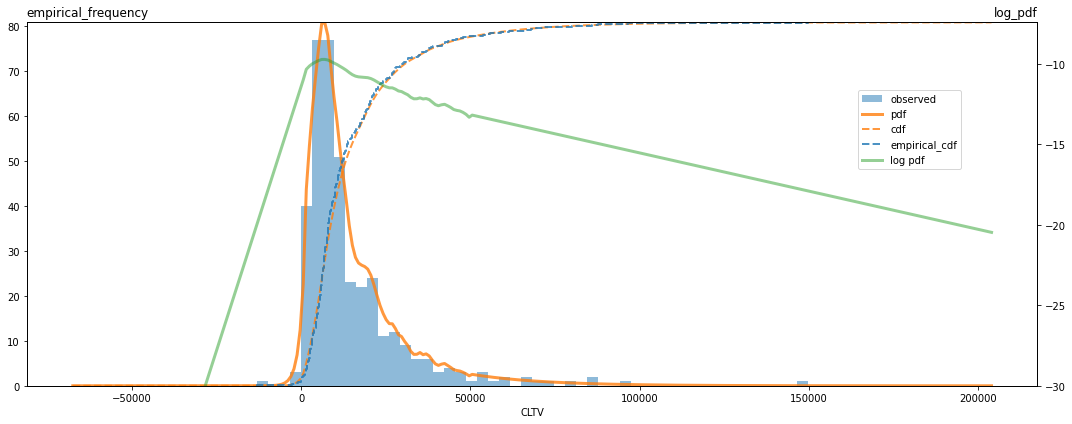

In [6]:
x = np.linspace(min_cltv - range_cltv/3, max_cltv + range_cltv/3, 300)
y_pdf = np.exp(reference_distribution.logp(x).eval())
y_pdf /= max(y_pdf)
y_cdf = np.cumsum(y_pdf) / sum(y_pdf)
y_log = reference_distribution.logp(x).eval()

fig, ax = plt.subplots(figsize=(15,6))
ax2 = ax.twinx()
ax3 = ax.twinx()
ax.hist(empirical_cltvs, bins=50, alpha=0.5, label='observed')
ax2.plot(x, y_pdf, alpha=0.8, lw=3, color='C1', label='pdf')
ax2.plot(x, y_cdf, alpha=0.8, lw=2, color='C1', ls='--', label='cdf')
ax3.plot(x, y_log, alpha=0.5, lw=3, color='C2', label='log pdf')
ax3.set_ylim(bottom = -30)
ax.set_title('empirical_frequency', loc='left')
ax3.set_title('log_pdf', loc='right')
ax2.tick_params(right=False, labelright=False)
sns.ecdfplot(data=empirical_cltvs, ax=ax2, ls='--', lw=2, alpha=0.8, label='empirical_cdf')
fig.legend(loc=(0.8, 0.6))
ax.set_xlabel('CLTV')
plt.tight_layout();

# Datasets

In [7]:
# SCALING_FACTOR = np.exp(-0.2)
# SHIFT_AMOUNT = 5000.

In [8]:
def generate_smoothly_transformed_datasets(size, tau, n_datasets=1000):
    transformed_pdf_pts = pdf_grid * np.exp(tau * x_grid)
    transformed_dist = pm.Interpolated.dist(x_grid, transformed_pdf_pts)
    scaling_factor = (((transformed_pdf_pts * x_grid).sum() / transformed_pdf_pts.sum())
                      / ((pdf_grid * x_grid).sum() / pdf_grid.sum()))
    return [transformed_dist.random(size=size) for i in range(n_datasets)], scaling_factor

In [9]:
def generate_smoothly_transformed_datasets_by_quantile(size, quantile_list, n_datasets=1000):
    datasets = []
    for q in quantile_list:
        tau = np.random.normal(-0.000005, 0.00001)
        ds, sf = generate_smoothly_transformed_datasets(size, tau, n_datasets)
        ds = [(d, d.mean()) for d in ds]
        ds.sort(key=lambda x: x[1])
        index = int(q * (n_datasets - 1))
        datasets.append((f'smt_{size}_q_{q}',
                         ds[index][0],
                         sf))
    return datasets

In [10]:
def generate_datasets(size, quantile_list, n_datasets=1000):
    datasets = [reference_distribution.random(size=size) for i in range(n_datasets)]
    datasets = [(d, d.mean()) for d in datasets]
    datasets.sort(key=lambda x: x[1])
    index_list = [int(q * (n_datasets - 1)) for q in quantile_list]
    scaling_factors = np.exp(np.random.normal(0, 0.2, size=len(index_list)))
    return [(f'sf_{size}_q_{quantile_list[i]}',
             datasets[idx][0] * scaling_factors[i],
             scaling_factors[i]) for i, idx in enumerate(index_list)]

In [11]:
QUANTILE_LIST = [0.05, 0.2, 0.8, 0.95]

In [12]:
sf_10 = generate_datasets(10, QUANTILE_LIST)
sf_30 = generate_datasets(30, QUANTILE_LIST)
sf_100 = generate_datasets(100, QUANTILE_LIST)
sf_300 = generate_datasets(300, QUANTILE_LIST)
sf_1000 = generate_datasets(1000, QUANTILE_LIST)
sf_3000 = generate_datasets(3000, QUANTILE_LIST)

In [13]:
smt_10 = generate_smoothly_transformed_datasets_by_quantile(10, QUANTILE_LIST)
smt_30 = generate_smoothly_transformed_datasets_by_quantile(30, QUANTILE_LIST)
smt_100 = generate_smoothly_transformed_datasets_by_quantile(100, QUANTILE_LIST)
smt_300 = generate_smoothly_transformed_datasets_by_quantile(300, QUANTILE_LIST)
smt_1000 = generate_smoothly_transformed_datasets_by_quantile(1000, QUANTILE_LIST)
smt_3000 = generate_smoothly_transformed_datasets_by_quantile(3000, QUANTILE_LIST)

In [14]:
shifted_negative = reference_distribution.random(size=1000) - 5000.
shifted_positive = reference_distribution.random(size=1000) + 5000.
scaled_then_shifted_a = reference_distribution.random(size=1000) * np.exp(0.3) - 7000.
scaled_then_shifted_b = reference_distribution.random(size=1000) * np.exp(-0.3) + 7000.
mixture_of_scaled = np.concatenate([reference_distribution.random(size=1000) * 0.5,
                                    reference_distribution.random(size=1000) * 1.5])

In [15]:
datasets = {
    'shifted_negative': shifted_negative,
    'shifted_positive': shifted_positive,
    'scaled_then_shifted_a': scaled_then_shifted_a,
    'scaled_then_shifted_b': scaled_then_shifted_b,
    'mixture_of_scaled': mixture_of_scaled,
}

datasets = {
    **datasets,
    **{t[0]: t[1] for t in sf_10},
    **{t[0]: t[1] for t in sf_30},
    **{t[0]: t[1] for t in sf_100},
    **{t[0]: t[1] for t in sf_300},
    **{t[0]: t[1] for t in sf_1000},
    **{t[0]: t[1] for t in sf_3000},
    **{t[0]: t[1] for t in smt_10},
    **{t[0]: t[1] for t in smt_30},
    **{t[0]: t[1] for t in smt_100},
    **{t[0]: t[1] for t in smt_300},
    **{t[0]: t[1] for t in smt_1000},
    **{t[0]: t[1] for t in smt_3000},
}

In [16]:
underlying_ratios = {
    'shifted_negative': 1.0 - 5000. / reference_distribution_mean,
    'shifted_positive': 1.0 + 5000. / reference_distribution_mean,
    'scaled_then_shifted_a': (reference_distribution_mean * np.exp(0.3) - 7000) / reference_distribution_mean,
    'scaled_then_shifted_b': (reference_distribution_mean * np.exp(-0.3) + 7000) / reference_distribution_mean,
    'mixture_of_scaled': 1.0,
}

underlying_ratios = {
    **underlying_ratios,
    **{t[0]: t[2] for t in sf_10},
    **{t[0]: t[2] for t in sf_30},
    **{t[0]: t[2] for t in sf_100},
    **{t[0]: t[2] for t in sf_300},
    **{t[0]: t[2] for t in sf_1000},
    **{t[0]: t[2] for t in sf_3000},
    **{t[0]: t[2] for t in smt_10},
    **{t[0]: t[2] for t in smt_30},
    **{t[0]: t[2] for t in smt_100},
    **{t[0]: t[2] for t in smt_300},
    **{t[0]: t[2] for t in smt_1000},
    **{t[0]: t[2] for t in smt_3000},
}

In [17]:
traces = {d: {} for d in datasets}

In [18]:
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.CRITICAL)

# Parameterisations

### Scaling factor

In [19]:
for d in datasets:
    with pm.Model():
        # prior
        log_scale_factor = pm.Uniform('log_scale_factor', -2.0, 2.0)

        # calculate the correct density in the transformed space
        def transformed_logp(value):
            return reference_distribution.logp(value/tt.exp(log_scale_factor)) - log_scale_factor

        # learn posterior for observed data
        cltv = pm.DensityDist('cltv', transformed_logp, observed=np.array(datasets[d]))
        traces[d]['scaling_factor'] = pm.sample(tune=500, draws=500, return_inferencedata=True, progressbar=False)
    print('.', end='')

.....................................................

### Scaling factor followed by a translation

In [20]:
# assumes shift happens after scaling
for d in datasets:
    with pm.Model():
        # prior
        log_scale_factor = pm.Uniform('log_scale_factor', -2.0, 2.0)
        translation = pm.Uniform('translation', -30000, 30000)

        # calculate the correct density in the transformed space
        def transformed_logp(value):
            return reference_distribution.logp((value-translation)/tt.exp(log_scale_factor)) - log_scale_factor

        # learn posterior for observed data
        cltv = pm.DensityDist('cltv', transformed_logp, observed=np.array(datasets[d]))
        traces[d]['scaling_factor_plus_translation'] = pm.sample(tune=500, draws=500,
                                                                 return_inferencedata=True, progressbar=False)
    print('.', end='')

.....................................................

### Smooth probability transform `p(x) -> p(x) * k * exp(x * tau)`

In [21]:
x_grid = np.linspace(reference_distribution.x_points.min(), reference_distribution.x_points.max(), 100000)
pdf_grid = np.exp(reference_distribution.logp(x_grid).eval())

for d in datasets:
    with pm.Model():
        # prior
        tau = pm.Uniform('tau', -0.0002, 0.00005)

        # tau determines k as area under pdf must sum to 1.0
        tau_grid = pdf_grid * tt.exp(x_grid * tau)
        k = pdf_grid.sum() / tau_grid.sum()

        # calculate the correct density in the transformed space
        def transformed_logp(value):
            return reference_distribution.logp(value) + (tau * value) + tt.log(k)

        # learn posterior for observed data
        cltv = pm.DensityDist('cltv', transformed_logp, observed=np.array(datasets[d]))
        traces[d]['smooth_transform'] = pm.sample(tune=500, draws=500, return_inferencedata=True, progressbar=False)
    print('.', end='')

.....................................................

### Normal distribution

In [22]:
for d in datasets:
    with pm.Model():
        # prior
        mu = pm.Uniform('mu', 0, 50000)
        sd = pm.Uniform('sd', 1000, 100000)

        # learn posterior for observed data
        cltv = pm.Normal('cltv', mu=mu, sigma=sd, observed=np.array(datasets[d]))
        traces[d]['normal'] = pm.sample(tune=500, draws=500, return_inferencedata=True, progressbar=False)
    print('.', end='')

.....................................................

### Gamma distribution

In [23]:
# for d in datasets:
#     with pm.Model():
#         # prior
#         alpha = pm.Uniform('alpha', 0, 20.)
#         beta = pm.Uniform('beta', 0.00001, 0.005)
#         loc = pm.Uniform('loc', -100000., 10000.)

#         # learn posterior for observed data
#         cltv = pm.Gamma('cltv', alpha=alpha, beta=beta, observed=np.array(datasets[d]) - loc)
#         traces[d]['gamma'] = pm.sample(tune=2000, draws=2000, return_inferencedata=True)
# #         pm.plot_trace(traces[d]['gamma'])

### Plot

In [24]:
def get_cltv_ratios_from_scale_then_shift(trace):
    scale = np.exp(trace.posterior.log_scale_factor.values).ravel()
    loc = trace.posterior.translation.values.ravel()
    return ((reference_distribution_mean * scale) + loc) / reference_distribution_mean

def get_cltv_ratios_from_smooth_transform(trace):
    tau = trace.posterior.tau.values.ravel()
    tau_grid = pdf_grid * np.exp(np.multiply.outer(x_grid, tau)).T
    k = (pdf_grid.sum() / tau_grid.sum(axis=1)).reshape(-1,1)
    return (k * tau_grid * x_grid).sum(axis=1) / (pdf_grid * x_grid).sum()

def get_cltv_ratios_from_normal(trace):
    mu = trace.posterior.mu.values.ravel()
    return mu / reference_distribution_mean

def get_cltv_ratios_from_gamma(trace):
    alpha = trace.posterior.alpha.values.ravel()
    beta = trace.posterior.beta.values.ravel()
    return (alpha / beta) / reference_distribution_mean

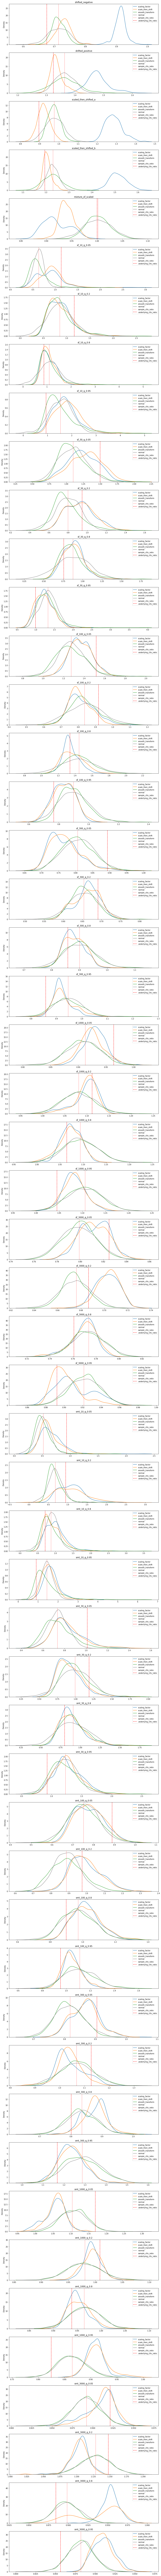

In [25]:
fig, axs = plt.subplots(len(datasets), figsize=(15, 5*len(datasets)))
for i, d in enumerate(datasets):
    # calculate CLTV of sample
    scale_then_shift_cltv_ratios = get_cltv_ratios_from_scale_then_shift(traces[d]['scaling_factor_plus_translation'])
    smooth_transform_cltv_ratios = get_cltv_ratios_from_smooth_transform(traces[d]['smooth_transform'])
    normal_cltv_values = get_cltv_ratios_from_normal(traces[d]['normal'])
#     gamma_cltv_values = get_cltv_ratios_from_gamma(traces[d]['gamma'])
    
    # plot distribution of CLTV value learned by each parameterisation
    sns.kdeplot(np.exp(traces[d]['scaling_factor'].posterior.log_scale_factor.values.ravel()),
                ax=axs[i],
                label='scaling_factor')
    sns.kdeplot(scale_then_shift_cltv_ratios, ax=axs[i], label='scale_then_shift')
    sns.kdeplot(smooth_transform_cltv_ratios, ax=axs[i], label='smooth_transform')
    sns.kdeplot(normal_cltv_values, ax=axs[i], color='gray', label='normal')
#     sns.kdeplot(gamma_cltv_values, ax=axs[i], color='gray', ls='--', label='gamma')
    
    # plot actual CLTV ratio as a vertical line
    axs[i].axvline(datasets[d].mean() / reference_distribution_mean, color='r', ls=':', label='sample_cltv_ratio')
    axs[i].axvline(underlying_ratios[d], color='r', ls='--', label='underlying_cltv_ratio')
    axs[i].legend()
    axs[i].set_title(d)

In [26]:
results = []
for d in datasets:
    pop_mean = underlying_ratios[d]
    result = {
        'dataset': d,
        'pop_mean': pop_mean,
        'sample_mean': datasets[d].mean() / reference_distribution_mean,
        'scale_factor_mse': (
            (np.exp(traces[d]['scaling_factor'].posterior.log_scale_factor.values.ravel()) - pop_mean) ** 2
        ).mean(),
        'scale_then_shift_mse': (
            (get_cltv_ratios_from_scale_then_shift(traces[d]['scaling_factor_plus_translation']) - pop_mean) ** 2
        ).mean(),
        'smooth_transform_mse': (
            (get_cltv_ratios_from_smooth_transform(traces[d]['smooth_transform']) - pop_mean) ** 2
        ).mean(),
        'normal_mse': (
            (get_cltv_ratios_from_normal(traces[d]['normal']) - pop_mean) ** 2
        ).mean(),                                    
    }
    results.append(result)
    print('.', end='')
    
results = pd.DataFrame(results)

.....................................................

In [ ]:
res = results.copy()
mse_cols = [c for c in res.columns if c.endswith('mse')]
smt_rows = res['dataset'].str.startswith('smt')
sf_rows = res['dataset'].str.startswith('sf')
other_rows = sf_rows.apply(lambda x: not(x)) & smt_rows.apply(lambda x: not(x))
res[mse_cols] = res[mse_cols].div(res['normal_mse'], axis=0)

In [45]:
res[mse_cols].loc[sf_rows].mean(), res[mse_cols].loc[sf_rows].median()

(scale_factor_mse        0.640351
 scale_then_shift_mse    0.666496
 smooth_transform_mse    0.969662
 normal_mse              1.000000
 dtype: float64,
 scale_factor_mse        0.541145
 scale_then_shift_mse    0.540587
 smooth_transform_mse    0.983809
 normal_mse              1.000000
 dtype: float64)

In [46]:
res[mse_cols].loc[smt_rows].mean(), res[mse_cols].loc[smt_rows].median()

(scale_factor_mse        1.623810
 scale_then_shift_mse    1.484996
 smooth_transform_mse    1.046399
 normal_mse              1.000000
 dtype: float64,
 scale_factor_mse        1.160302
 scale_then_shift_mse    1.159879
 smooth_transform_mse    0.975166
 normal_mse              1.000000
 dtype: float64)

In [47]:
res[mse_cols].loc[other_rows].mean(), res[mse_cols].loc[other_rows].median()

(scale_factor_mse        22.873200
 scale_then_shift_mse     1.423319
 smooth_transform_mse     1.074782
 normal_mse               1.000000
 dtype: float64,
 scale_factor_mse        17.384523
 scale_then_shift_mse     0.256490
 smooth_transform_mse     0.819069
 normal_mse               1.000000
 dtype: float64)

# Appendix 1

### Mixture of two scaled reference distributions

Not used as this was unstable at learning

In [28]:
# for d in datasets:
#     with pm.Model():
#         # prior
#         log_scale_factor1 = pm.Uniform('log_scale_factor1', -2.0, 2.0)
#         log_scale_factor2_diff = pm.Uniform('log_scale_factor2_diff', 0.0, 4.0)
#         log_scale_factor2 = log_scale_factor1 + log_scale_factor2_diff
#         share_of_component_1 = pm.Uniform('share_of_component_1', 0.0, 1.0)
#         share_of_component_2 = 1 - share_of_component_1

#         # calculate the correct density in the transformed space
#         def transformed_logp(value):
#             p_from_mix_1 = share_of_component_1 * tt.exp(reference_distribution
#                                                          .logp(value/tt.exp(log_scale_factor1))
#                                                          - log_scale_factor1)
#             p_from_mix_2 = share_of_component_2 * tt.exp(reference_distribution
#                                                          .logp(value/tt.exp(log_scale_factor2))
#                                                          - log_scale_factor2)
#             return tt.log(p_from_mix_1 + p_from_mix_2)

#         # learn posterior for observed data
#         cltv = pm.DensityDist('cltv', transformed_logp, observed=np.array(datasets[d]))
#         traces[d]['mixture_model'] = pm.sample(tune=2000, draws=2000, return_inferencedata=True)

# Appendix 2: Thoughts on coming up with a prior over the scale factor
A common test setup is to have control and test branches where we are looking to estimate the uplift of some metric on the test branch relative to the control branch. Usually we will collect the prior over this uplift from the business. However we also need a prior over the baseline level of the metric in the control branch in order to interpret the observed data from both branches in true A/B fashion.

If the metric in question is `E(CLTV|loan)`, and we expect that the control branch will behave similarly to the recent past, we could use recent loan values to derive a prior over the control scale factor as follows: update an initial non-informative prior (e.g. uniform in log space between sufficiently wide bounds) to yield the posterior distribution over scale factor for these recent observed data. Use this as the control branch prior over the scale factor for our test. The strength of this prior could be altered by flexing the number of recent loans used (e.g. by (down)sampling at regular intervals in the cdf of recent loans) - analogous to dividing the parameters of a beta prior to adjust for relative confidence - or applying a stretching factor to the resultant prior e.g. by a factor - analogous to the √n that determines sample standard deviation for a normal distribution.
